# Overall Summary of Observations:

1) This dataset looks continuous and doesn't have any associated downtime
   Probably no failure points associated with it  <br>
2) Current and Voltage Information showed a trend <br>
3) The mean shifting of current and voltage trend happened at the same point <br>
4) Introduced a event associated to the point at which there is a shift in trend as there is no market failure <br>
5) Highlighted them in the dataset <br>

# Probable Next Steps <br>

1) To make a large problem for test cases, we can create a simulated dataset based on the trend of current & voltage <br>
2) Introduce a bit of randomness in variability on the simulated dataset within each cycle <br>
3) Split the dataset into training, testing, validation based on the cycle id <br>
4) Identify the failure point at which there is a shift in trend and mark this as end of life <br>
5) Develop a regression or classification model either to predict the RUL or to identify the failure based on each cycle <br>
6) Develop Message Topic to stream these simulated messages in Real-Time <br>
7) Plot the streamed messages in real time <br>
8) Perform predictions for the real time messages <br>
9) Validate with Customers<br>

Extract Dataset Performal Initial Exploration

In [283]:
import pandas as pd

circuit_data = pd.read_csv("C:/Users/18646/Desktop/test_data.csv")

print ("# of Records in Circuit Data =", len(circuit_data))
print (circuit_data.head())

# of Records in Circuit Data = 129603
   Unnamed: 0            timestamp      value     unit
0           0  2021-02-17 11:00:00  -2.197474  current
1           0  2021-02-17 11:00:00   0.000000    deg C
2           0  2021-02-17 11:00:00 -35.498223  voltage
3           1  2021-02-17 11:00:01  -3.206576  current
4           1  2021-02-17 11:00:01  -0.140105    deg C


In [284]:
# It looks like each timestamp contains the information related current, deg and voltage
# Convert into pivot table to visualize the dataset even better

print ("# of Unit Types =", circuit_data['unit'].unique())
# The values in each row might be corresponding to current, deg and voltage

circuit_pivot  =circuit_data.pivot(index='timestamp', columns='unit', values='value').reset_index()
circuit_pivot.index = pd.to_datetime(df_pivot['timestamp'])

circuit_pivot.drop(columns = {'timestamp'}, inplace = True)
print ("# of Records = ", len(circuit_pivot))

# of Unit Types = ['current' 'deg C' 'voltage']
# of Records =  43201


In [285]:
circuit_pivot.head()

unit,current,deg C,voltage
timestamp,,,
2021-02-17 11:00:00,-2.197474,0.000000,-35.498223
2021-02-17 11:00:01,-3.206576,-0.140105,-52.058587
2021-02-17 11:00:02,-3.912182,-0.153092,-63.543396
2021-02-17 11:00:03,-4.215925,-0.050858,-68.228204
2021-02-17 11:00:04,-4.258216,-0.195115,-69.267085


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>], dtype=object)

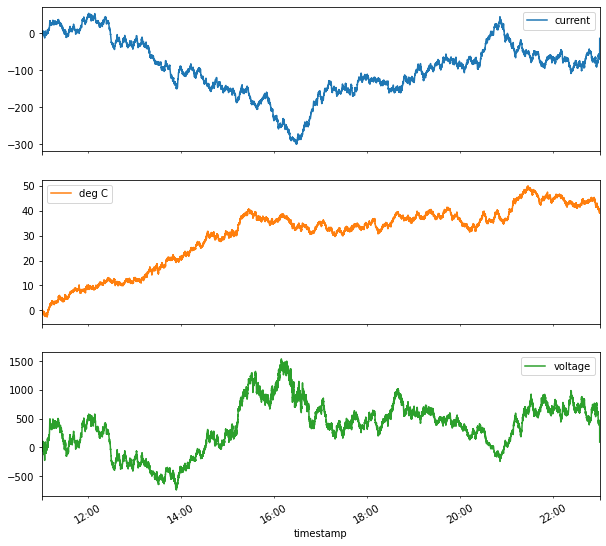

In [286]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


circuit_pivot.plot(subplots = True, figsize = (10,10))

In [287]:
# From the graph it looks like temperature is just getting increased
# Maybe the temperature maybe here the operating temperature and it gets incremented as the machine is operated for long hours

# Current and Voltage shows some pattern, especially current it could be a case where a tool or machine is completed execution
# that the value drops and then starts to increase again

# Check for time difference to see if there is a downtime

In [288]:
circuit_pivot['time_diff'] = circuit_pivot.index.to_series().diff().dt.seconds
circuit_pivot['time_diff'] = circuit_pivot['time_diff'].fillna(0)

In [289]:
circuit_pivot['time_diff'].unique()

array([0., 1.])

In [290]:
circuit_pivot.loc[circuit_pivot['time_diff'] == 0]

unit,current,deg C,voltage,time_diff
timestamp,,,,
2021-02-17 11:00:00,-2.197474,0.0,-35.498223,0.0


In [291]:
# Looks like the only record with the time_diff of 0 is the first record

# Observation: Probably there is no downtime or failure in this case and the data is collected at a frequency of 1 second

In [292]:
# Just for curiosity let's assume a case where the shift in current from end of cycle to a beginning as an event

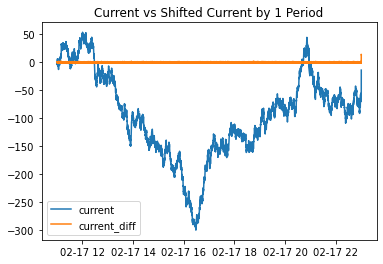

In [293]:
circuit_pivot['current_diff'] = circuit_pivot.current.diff(periods =1).fillna(0)
circuit_pivot['voltage_diff'] = circuit_pivot.voltage.diff(periods =1).fillna(0)

plt.title("Current vs Shifted Current by 1 Period")
plt.plot(circuit_pivot[['current','current_diff']])
plt.legend(['current', 'current_diff'])



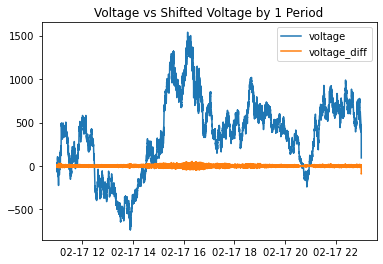

In [294]:
plt.title("Voltage vs Shifted Voltage by 1 Period")
plt.plot(circuit_pivot[['voltage','voltage_diff']])
plt.legend(['voltage', 'voltage_diff'])

In [295]:
# From the data it looks like there is no sudden shift in trend between the next cycle and previous cycle

# Let's see if there is a shift in trend between previous cycle and a window of 1000 cycles


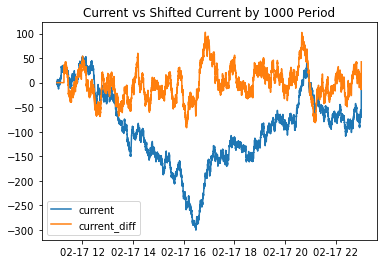

In [296]:
circuit_pivot['current_diff'] = circuit_pivot.current.diff(periods =1000).fillna(0)
circuit_pivot['voltage_diff'] = circuit_pivot.voltage.diff(periods =1000).fillna(0)

plt.title("Current vs Shifted Current by 1000 Period")
plt.plot(circuit_pivot[['current','current_diff']])
plt.legend(['current', 'current_diff'])

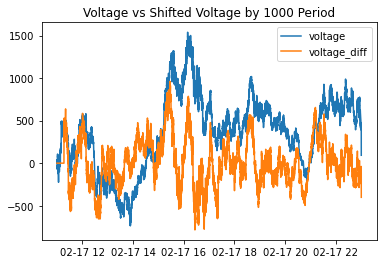

In [297]:
plt.title("Voltage vs Shifted Voltage by 1000 Period")
plt.plot(circuit_pivot[['voltage','voltage_diff']])
plt.legend(['voltage', 'voltage_diff'])

In [298]:
# It looks like a window of 1000 cycles provide a good representation of data

# Lets identify the point at which a higher shift in trend happens

In [299]:
circuit_pivot['current_diff'].describe()

count    43201.000000
mean        -1.780098
std         31.528543
min        -92.006386
25%        -22.041309
50%         -3.145888
75%         17.284849
max        102.796474
Name: current_diff, dtype: float64

In [300]:
circuit_pivot['voltage_diff'].describe()

count    43201.000000
mean         9.363433
std        273.113597
min       -784.628374
25%       -165.622125
50%          0.000000
75%        180.079893
max        961.428642
Name: voltage_diff, dtype: float64

In [301]:
# The max value stand out from 

In [302]:
min_current, min_volt = circuit_pivot['current_diff'].min(),circuit_pivot['voltage_diff'].min()
max_current, max_volt = circuit_pivot['current_diff'].max(), circuit_pivot['voltage_diff'].max()


# Lets assume that the max value as an event where failure has happened
change_point = circuit_pivot.loc[circuit_pivot['current_diff'].isin([max_current, max_volt])]
timestamp_fail = change_point.index
print ("Change Point = " , "\n", change_point)


Change Point =  
 unit                    current      deg C     voltage  time_diff  \
timestamp                                                           
2021-02-17 16:51:06 -184.784515  31.230772  345.106735        1.0   

unit                 current_diff  voltage_diff  
timestamp                                        
2021-02-17 16:51:06    102.796474   -355.934093  


In [303]:
circuit_pivot = circuit_pivot.reset_index()
print ("Circuit Pivot = ", circuit_pivot.head())

Circuit Pivot =  unit           timestamp   current     deg C    voltage  time_diff  \
0    2021-02-17 11:00:00 -2.197474  0.000000 -35.498223        0.0   
1    2021-02-17 11:00:01 -3.206576 -0.140105 -52.058587        1.0   
2    2021-02-17 11:00:02 -3.912182 -0.153092 -63.543396        1.0   
3    2021-02-17 11:00:03 -4.215925 -0.050858 -68.228204        1.0   
4    2021-02-17 11:00:04 -4.258216 -0.195115 -69.267085        1.0   

unit  current_diff  voltage_diff  
0              0.0           0.0  
1              0.0           0.0  
2              0.0           0.0  
3              0.0           0.0  
4              0.0           0.0  


In [304]:
fail_index = circuit_pivot[circuit_pivot['timestamp'] == timestamp_fail[0]].index

# The biggest shift in voltage and current happens at the same timestamp

In [305]:
print ("Failure Point = ", change_point.index)

circuit_pivot['Event_End'] = False
#circuit_pivot.loc[circuit_pivot['current_diff'].isin([max_current, max_volt]), 'Event_Beginning'] = True
circuit_pivot.loc[circuit_pivot.index == fail_index[0] -1000, 'Event_End'] = True

Failure Point =  DatetimeIndex(['2021-02-17 16:51:06'], dtype='datetime64[ns]', name='timestamp', freq=None)


In [306]:
#circuit_pivot.to_csv("C:/Users/18646/Desktop/Test_again.csv")

In [307]:
import plotly.express as px

fig = px.line(circuit_pivot, x = circuit_pivot.index, y="current", color='Event_End')
fig.data[1].update(mode='markers+lines')
#fig.add_scatter( x = circuit_pivot.index, y="current_diff") 

fig
